# Part 1: Scraping

The below code was built to be run as a Python file and as a one-daily-run solution.

In [15]:
import praw
import random
import pandas as pd
import datetime
from time import sleep
from prawcore.exceptions import Forbidden
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chisquare

In [5]:
# Define amount of controla and experiment groups to scrape.
number_of_posts = 100
# File name for scraped posts.
file_name = "Data/reddit_experiment_with_comments_test_0.pickle"

Define login parameters

In [6]:
def user_login(client_id, client_secret, username, password, user_agent):
    reddit = praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        username=username,
        password=password,
        user_agent=user_agent,
    )
    return reddit


reddit = user_login(
    "secret :)",
    "secret :)",
    "RareBodybuilder3469",
    "secret :)",
    "Mozilla/5.0",
)

Function to upvote posts

In [7]:
def upvote_single_post(user_id):
    submission = reddit.submission(id=user_id)
    try:
        submission.upvote()
    except:
        return 0

Get x (number_of_posts) amount of random new posts from the "all" SubReddit.

In [8]:
def get_onehundred_new_posts():
    one_hundred_new_posts = []
    for post in reddit.subreddit("all").new():
        try:
            one_hundred_new_posts.append(post.id)
            submission = reddit.submission(id=post.id)
        except:
            one_hundred_new_posts.remove(post.id)
    return one_hundred_new_posts

Check if file exists (With previous days dataframe), if not then defind a new dataframe with columns.

In [6]:
try:
    df = pd.read_pickle(file_name)
except FileNotFoundError:
    df = pd.DataFrame(
        columns=[
            "start_date",
            "post_id",
            "group",
            "day_0",
            "day_1",
            "day_2",
            "day_3",
            "day_4",
            "day_5",
            "day_6",
            "day_0_comments",
            "day_1_comments",
            "day_2_comments",
            "day_3_comments",
            "day_4_comments",
            "day_5_comments",
            "day_6_comments",
        ]
    )

Check if today > day_0 + 7, if then only run the update (Vote and comment count) loop if not then also run loop to pull new posts.

In [7]:
today = datetime.date.today()
count_ex = 0
count_con = 0
error_list = []

try:
    loop = (min(df["start_date"]) + datetime.timedelta(days=6)) <= today or len(df["start_date"]) != 1800
except:
    loop = True

Function to retry upvote, should it fail. 

In [8]:
def upvote_retry(post_id):
    try:
        upvote = upvote_single_post(post_id)
        return upvote
    except:
        sleep(60)
        return 1

Loop to initialize new rows for control and experiment posts, also check that posts have no upvotes and comments.

In [ ]:
if loop:
    while count_ex != number_of_posts and count_con != number_of_posts:
        # if len(error_list) == 10:
        #     break
        print(f"New post progress {round(((count_ex + count_con)/(number_of_posts * 2))*100, 2)}%", end='\r')
        posts = get_onehundred_new_posts()
        for post_id in posts:
            if post_id not in df["post_id"] and post_id not in df["post_id"]:
                submission = reddit.submission(post_id)
                com = submission.num_comments
                if submission.score == 1 and com == 0:
                    if random.randint(0, 1) and count_ex != number_of_posts:
                        upvote = 1
                        while upvote == 1:
                            upvote = upvote_retry(post_id)
                        if upvote != 0:
                            df.loc[len(df)] = [today, post_id, "experiment", 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                            count_ex += 1
                            print(f"New post progress {round(((count_ex + count_con)/(number_of_posts * 2))*100, 2)}%", end='\r')
                        else:
                            error_list.append(0)
                            print("Sleeping... Please wait.", end='\r')
                            sleep(60)
                    elif count_con != number_of_posts:
                        df.loc[len(df)] = [today, post_id, "control", 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                        count_con += 1
                        print(f"New post progress {round(((count_ex + count_con)/(number_of_posts * 2))*100, 2)}%", end='\r')

Update the previously pulled data. Also contains conditions to manage Reddit denying requests.

In [ ]:

if today <= (max(df["start_date"]) + datetime.timedelta(days=6)):
    for index, row in df.iterrows():
        print(f"Updating progress {round((index/(len(df. index))*100), 2)}%", end='\r')
        if today <= (row["start_date"] + datetime.timedelta(days=6)):
            try:
                submission = reddit.submission(row["post_id"])
            except:
                print("Sleeping... Please wait.", end='\r')
                sleep(10)
                submission = reddit.submission(row["post_id"])
            if (row["start_date"] + datetime.timedelta(days=1)) == today:
                try:
                    df.loc[index, "day_1"] = submission.score
                    df.loc[index, "day_1_comments"] = submission.num_comments
                except:
                    print("Sleeping... Please wait.", end='\r')
                    sleep(10)
                    try:
                        df.loc[index, "day_1"] = submission.score
                        df.loc[index, "day_1_comments"] = submission.num_comments
                    except Forbidden:
                        df.loc[index, "day_1"] =  df.loc[index, "day_0"]
                        df.loc[index, "day_1_comments"] =  df.loc[index, "day_0_comments"]
            elif (row["start_date"] + datetime.timedelta(days=2)) == today:
                try:
                    df.loc[index, "day_2"] = submission.score
                    df.loc[index, "day_2_comments"] = submission.num_comments
                except:
                    print("Sleeping... Please wait.", end='\r')
                    sleep(10)
                    try:
                        df.loc[index, "day_2"] = submission.score
                        df.loc[index, "day_2_comments"] = submission.num_comments
                    except Forbidden:
                        df.loc[index, "day_2"] =  df.loc[index, "day_1"]
                        df.loc[index, "day_2_comments"] =  df.loc[index, "day_1_comments"]
            elif (row["start_date"] + datetime.timedelta(days=3)) == today:
                try:
                    df.loc[index, "day_3"] = submission.score
                    df.loc[index, "day_3_comments"] = submission.num_comments
                except:
                    print("Sleeping... Please wait.", end='\r')
                    sleep(10)
                    try:
                        df.loc[index, "day_3"] = submission.score
                        df.loc[index, "day_3_comments"] = submission.num_comments
                    except Forbidden:
                        df.loc[index, "day_3"] =  df.loc[index, "day_2"]
                        df.loc[index, "day_3_comments"] =  df.loc[index, "day_2_comments"]
            elif (row["start_date"] + datetime.timedelta(days=4)) == today:
                try:
                    df.loc[index, "day_4"] = submission.score
                    df.loc[index, "day_4_comments"] = submission.num_comments
                except:
                    print("Sleeping... Please wait.", end='\r')
                    sleep(10)
                    try:
                        df.loc[index, "day_4"] = submission.score
                        df.loc[index, "day_4_comments"] = submission.num_comments
                    except Forbidden:
                        df.loc[index, "day_4"] =  df.loc[index, "day_3"]
                        df.loc[index, "day_4_comments"] =  df.loc[index, "day_3_comments"]
            elif (row["start_date"] + datetime.timedelta(days=5)) == today:
                try:
                    df.loc[index, "day_5"] = submission.score
                    df.loc[index, "day_5_comments"] = submission.num_comments
                except:
                    print("Sleeping... Please wait.", end='\r')
                    sleep(10)
                    try:
                        df.loc[index, "day_5"] = submission.score
                        df.loc[index, "day_5_comments"] = submission.num_comments
                    except Forbidden:
                        df.loc[index, "day_5"] =  df.loc[index, "day_4"]
                        df.loc[index, "day_5_comments"] =  df.loc[index, "day_4_comments"]
            elif (row["start_date"] + datetime.timedelta(days=6)) == today:
                try:
                    df.loc[index, "day_6"] = submission.score
                    df.loc[index, "day_6_comments"] = submission.num_comments
                except:
                    print("Sleeping... Please wait.", end='\r')
                    sleep(10)
                    try:
                        df.loc[index, "day_6"] = submission.score
                        df.loc[index, "day_6_comments"] = submission.num_comments
                    except Forbidden:
                        df.loc[index, "day_6"] =  df.loc[index, "day_5"]
                        df.loc[index, "day_6_comments"] =  df.loc[index, "day_5_comments"]

Save progress to file.

In [ ]:
df.to_pickle(file_name)

# Part 2: Analysis

Reading the 'pickled' dataframe from the scraping step prior

In [2]:
df = pd.read_pickle(r'Data/reddit_experiment_with_comments_cut.pickle')

We extract the final post scores and split them up as *control* and *treatment* groups

In [18]:
control = df[df['group'] == 'control']['day_6']
experiment = df[df['group'] == 'experiment']['day_6'][:len(control)]

We check the distribution of upvotes

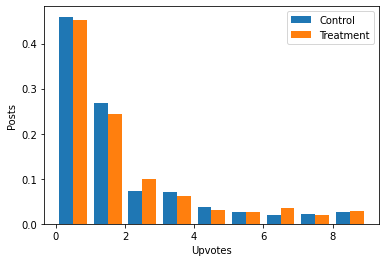

In [19]:
bins=range(10)
plt.hist([control, experiment], bins, density=True, label=['Control', 'Treatment'])
plt.legend(loc='upper right')
plt.xlabel('Upvotes')
plt.ylabel('Posts')
plt.show()

## Binomial test

We either deem a post successfull/unsuccessfull based on a threshold of the score; in our case a score of 10 points or more.

In [20]:
control_counts = Counter([1 if a >= 10 else 0 for a in control])
experiment_counts = Counter([1 if a >= 10 else 0 for a in experiment])

control_totals = [control_counts[0], control_counts[1]]
experiment_totals = [experiment_counts[0], experiment_counts[1]]

Chi-square test of proportions

In [21]:
chisquare(control_totals, f_exp=experiment_totals)

Power_divergenceResult(statistic=3.830531964668018, pvalue=0.05032695754533978)